# Face Detection

- many classes, but very few samples of each

#### Topics:

- Face Recegnition
- Siamese Network
- Trople loss 
- Defining and implementing dataset

## Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps   
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms

from utils import to_var
from data_utils import create_validation_data

use_gpu = torch.cuda.is_available()

In [2]:
use_gpu

False

### Helper Methods 

In [3]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)

def imshow(img, text=None):
    # convert from torch tensor to numpy array
    img_np = img.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    
    # denormalize
    img_np = img_np * std + mean
    img_np = img_np.clip(0., 1.)
    
    # plot
    plt.axis("off")
    if text:
        plt.text(160, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()


def show_image_pair(img1, img2, text=None):
    concat = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), 0)
    imshow(torchvision.utils.make_grid(concat), text)

## Data

In [4]:
DATA_DIR = '/Users/mahrokh/Desktop/faceAT'
train_dir = f'{DATA_DIR}/train'
valid_dir = f'{DATA_DIR}/valid'

sz = 224
batch_size = 16
embed_size = 128
num_epochs = 10

cnn_name = 'resnet101'

In [5]:
# create valid folder and data in it
# if you run it more, it'll take more pictures in valid sub-folders
'''import shutil, sys    
className = ['s34','s33','s5','s2','s32','s35','s3','s4','s26','s19','s21','s17','s28',
             's10','s11','s16','s29','s20','s27','s18','s8','s1','s6','s39','s30','s37',
             's7','s9','s36','s31','s38','s22','s25','s13','s14','s40','s15','s12','s24',
             's23']

DATA_DIR = '/Users/mahrokh/Desktop/faceAT'
train_dir = f'{DATA_DIR}/train/'
valid_dir = f'{DATA_DIR}/valid/'

#os.mkdir(valid_dir)
for i in range(len(className)):
    os.mkdir(f'{DATA_DIR}/valid/{className[i]}')
    
for i in range(len(className)):
    source = f'{train_dir}{className[i]}'
    dest = f'{valid_dir}{className[i]}'
    
    files = os.listdir(source)
    no_of_files = len(files) // 5
    
    for file_name in random.sample(files, no_of_files):
        shutil.move(os.path.join(source, file_name), dest)'''

"import shutil, sys    \nclassName = ['s34','s33','s5','s2','s32','s35','s3','s4','s26','s19','s21','s17','s28',\n             's10','s11','s16','s29','s20','s27','s18','s8','s1','s6','s39','s30','s37',\n             's7','s9','s36','s31','s38','s22','s25','s13','s14','s40','s15','s12','s24',\n             's23']\n\nDATA_DIR = '/Users/mahrokh/Desktop/faceAT'\ntrain_dir = f'{DATA_DIR}/train/'\nvalid_dir = f'{DATA_DIR}/valid/'\n\n#os.mkdir(valid_dir)\nfor i in range(len(className)):\n    os.mkdir(f'{DATA_DIR}/valid/{className[i]}')\n    \nfor i in range(len(className)):\n    source = f'{train_dir}{className[i]}'\n    dest = f'{valid_dir}{className[i]}'\n    \n    files = os.listdir(source)\n    no_of_files = len(files) // 5\n    \n    for file_name in random.sample(files, no_of_files):\n        shutil.move(os.path.join(source, file_name), dest)"

In [6]:
# dir(models) 

## Making Dataset

In [7]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
        if transform is None:
            self.transform = transforms.ToTensor()
        
    def __getitem__(self, index):
        
        anchor, anchor_label = self.imgs[index] 
        negetive = random.choice([img for img, label in self.imgs if label != anchor_label])
        positive = random.choice([img for img, label in self.imgs if label == anchor_label])
        
        # read pair of images
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negetive).convert('RGB')
        
        # perform given transformations (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

### Training data

In [8]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom
stats = ([0.50480222, 0.4073655, 0.37700788], [0.29478898, 0.25199998, 0.2384155])

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# training data
face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers = 8)


valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

# validation data
valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=True)

### Visualize Dataset

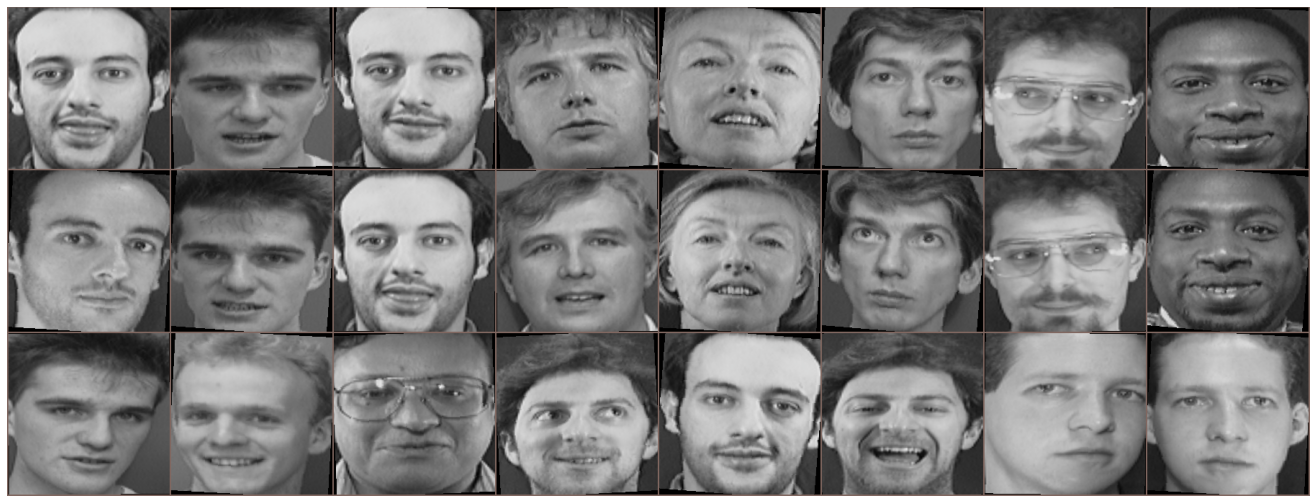

In [9]:
std = [0.29478898, 0.25199998, 0.2384155]
mean = [0.50480222, 0.4073655, 0.37700788]
iterablekrd = iter(train_dl)
anc_img, pos_img, neg_img = next(iterablekrd)
concat = torch.cat((anc_img, pos_img, neg_img), 0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

# Model: Triple Network

In [10]:
class TripleNetwork(nn.Module):
    def __init__ (self, model, embed_size):
        super(TripleNetwork, self).__init__()
        num_features = model.fc.in_features
        cnn.fc = nn.Sequential(
        nn.Linear(num_features, 512), 
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, embed_size))
        
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

# Loss: Triplet Loss

In [11]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - 
                                     torch.pow(neg_distance, 2)+ self.margin, min=0))
        return loss

# Train

In [12]:
def train_step(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    if scheduler:
        scheduler.step()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (imgs0, imgs1, lbls) in enumerate(train_dl):
        imgs0, imgs1, lbls = Variable(imgs0), Variable(imgs1), Variable(lbls)
        
        # forward
        features0, features1, lbls = model(imgs0, imgs1, lbls)
        
        # loss
        loss = criterion(features0, features1, lbls)
        avg_loss = (avg_loss * i + loss.data) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    for i, (imgs0, imgs1, lbls) in enumerate(valid_dl):
        imgs0 = to_var(imgs0, volatile=True)
        imgs1 = to_var(imgs1, volatile=True)
        lbls = to_var(lbls, volatile=True)
        
        features0, features1, lbls = model(imgs0, imgs1, lbls)
        loss = criterion(features0, features1, lbls)
        avg_loss = (avg_loss * i + loss.data) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Validation Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()
    
    return model, avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n--------')
        model, train_loss = train_step(model, train_dl, criterion, optimizer, scheduler)
        valid_loss = validate_step(model, valid_dl, criterion)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
            torch.save(best_weights, f'tmp/{cnn_name}-facereco-iranians-{epoch}-{best_loss}.pth')
        print()
        
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, loss_history

In [13]:
# training and validation data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

# model
cnn = get_model(cnn_name)
model = TripleNetwork(cnn, embed_size)

# loss and optimizer
criterion = TripletLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

In [14]:
model, loss_hist = train(model, train_dl, valid_dl, criterion, 
                         optimizer, scheduler, num_epochs=50)

Epoch 0
--------


/Users/mahrokh/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/Users/mahrokh/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, k

 Training Step [18/18]: loss 12.83709  


/Users/mahrokh/DeepLearning-razavi/lesson-2-faceDetection/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


 Validation Step [8/8]: loss 12.89148  


TypeError: '<' not supported between instances of 'tuple' and 'float'

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Testing:

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)

In [ ]:
model.eval()

dataiter = iter(valid_dl)
for i in range(20):
    x0, x1, _ = next(dataiter)
    concat = torch.cat((x0, x1), 0)
    x0, x1 = to_var(x0, volatile=True), to_var(x1, volatile=True)
    f0, f1 = model(x0, x1)
    euclidean_distance = F.pairwise_distance(f0, f1)
    imshow(torchvision.utils.make_grid(concat),
           mean=stats[0], std=stats[1],
           text='Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))